# Current Population Survey

## Imports

In [83]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from operator import itemgetter

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

#from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn import tree
from sklearn.tree import export_graphviz
import pydotplus



In [84]:
# sets any scikit transformer to output in a pandas dataframe
set_config(transform_output="pandas")

## Preprocessing

In [85]:
# read in the csv to a df
df = pd.read_csv('final_cps_data.csv')
df.head()

,year,state_fip,state,metro,relation_to_head_of_house,age,gender,race,marital_status,birthplace,...,protective,foodcare,building,sales,office_admin,farmer,construction,production,transport.2,transport.3
0,1990,36,NY,2.0,101,58,1,3,6,NaN,...,0,0,0,0,1,0,0,0,0,0
1,2009,5,AR,2.0,1260,28,1,1,6,9900.0,...,0,0,0,0,1,0,0,0,0,0
2,1990,36,NY,3.0,101,37,1,1,6,NaN,...,0,0,0,0,0,0,0,0,0,0
3,1990,6,CA,3.0,101,34,1,1,6,NaN,...,0,0,0,0,0,0,0,0,0,0
4,1981,51,VA,3.0,101,38,1,4,1,NaN,...,0,0,0,0,0,0,0,0,0,0


In [86]:
# filter dataset to 2013. Prevents YoY changes from negatively impacting our predictions by removing YoY variability
#df = df[df['year']==df['year'].max()]
df = df[df['year'] > 2001]
# cleaning out duplicate columns, columns with no mappings (can't translate numbers to categorical) and non-useful columns (all rows have same value)
firstcoldrops = ['metro','birthplace','race',
                 'state_fip','longest_job_earnings',
                 'hours_per_week','hourly_wage',
                 'wage_inflation_factor','year_of_immigration',
                 'real_hourly_wage','personal_consumption_expenditure',
                 'occupation_category','family_type','mother_birthplace',
                 'father_birthplace','citizen','foreign_birthplace',
                 'grade_level_achieved','worker_class_last_year',
                 'not_inputed_income']

In [87]:
# drop the columns
df = df.drop(firstcoldrops,axis=1)
df.head()


,year,state,relation_to_head_of_house,age,gender,marital_status,employment_status,worker_class,weeks_worked_last_year,union_member_status,...,protective,foodcare,building,sales,office_admin,farmer,construction,production,transport.2,transport.3
1,2009,AR,1260,28,1,6,10,21,52,1.0,...,0,0,0,0,1,0,0,0,0,0
6,2007,IL,101,44,1,1,10,21,52,0.0,...,0,0,0,0,0,0,0,1,0,0
9,2011,VT,201,55,1,1,12,21,52,0.0,...,0,0,0,0,0,0,0,0,0,1
10,2007,RI,101,51,1,1,10,21,52,0.0,...,0,0,0,1,0,0,0,0,0,0
11,2009,PA,101,43,1,3,10,21,52,0.0,...,0,0,0,0,0,0,1,0,0,0


In [88]:
# convert numeric codes to strings
df['relation_to_head_of_house'] = df['relation_to_head_of_house'].map({101:'Head', 
                                                                       201:'Spouse', 
                                                                       301:'Child', 
                                                                       303:'Stepchild', 
                                                                       501:'Parent', 
                                                                       701:'Sibling', 
                                                                       901:'Grandchild', 
                                                                       1001:'Other', 
                                                                       1113:'Partner', 
                                                                       1114:'Unmarried', 
                                                                       1115:'Housemate', 
                                                                       1241:'Roomer', 
                                                                       1242:'Foster', 
                                                                       126:'Other'})
df['relation_to_head_of_house'] = df['relation_to_head_of_house'].fillna('Uknown')
df['union_member_status'] = df['union_member_status'].fillna('Uknown')
df['marital_status'] = df['marital_status'].map({1:'Married Spouse Present', 
                                                2:'Married Spouse Absent', 
                                                3:'Separated', 
                                                4:'Divorced', 
                                                5:'Widowed', 
                                                6:'Never Married'})

df['worker_class'] = df['worker_class'].map({21:'Private Sector', 
                                                25:'Federal', 
                                                27:'State', 
                                                28:'Local', 
                                                29:'Unpaid Family Worker'})

df['employment_status'] = df['employment_status'].map({10:'Employed', 
                                                12:'Unemployed'})

df['gender'] = df['gender'].map({1:'Male', 
                                2:'Female'})

## Train Test Split

In [89]:
# set our target
TARGET = 'gender'

# create our X which are our features
X = df.copy()
# remove our target variable
X = X.drop(TARGET,axis=1)

# create our Y which is what we are predicting
Y = df.copy()
Y = Y[TARGET]

# print the shape to make sure that the X and Y 
# have the same number of rows
print(X.shape)
print(Y.shape)

(219731, 64)
(219731,)


In [90]:
# split our data
# keep 80% for training
# keep 20% for testing
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y, 
                                                    train_size=0.8,
                                                    test_size=.2,
                                                    stratify=Y)

In [91]:
# 1-hot encode our data
ohe = OneHotEncoder(handle_unknown = 'ignore',sparse_output=False)

# only fit the encoder to the categorical variables
# create a subset of just categorical variables for the train set
X_train_objects = X_train.select_dtypes('object')
# actually fit the encoder
ohe.fit(X_train_objects)

#create a subset of just categorical variables for the test set
X_test_objects = X_test.select_dtypes('object')

# for the training data set transform the categorical then concat it with the numerical
x_train_transformed = pd.concat((ohe.transform(X_train_objects),X_train.select_dtypes(exclude='object')),axis=1)

#do the same for test
x_test_transformed =  pd.concat((ohe.transform(X_test_objects),X_test.select_dtypes(exclude='object')),axis=1)

## All Variables Logistic Regression

In [92]:
# get the coefficients function
# this function just returns a dictionary of the coefficient and the feature
def getCoefLogit( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_[0]
    for coef, feat in zip(MODEL.coef_[0],varNames):
        coef_dict[feat] = coef
    return coef_dict

In [93]:
x_train_transformed.isnull().sum().sort_values(ascending=False)

state_56               0
high_school_or_less    0
transport              0
nondurables            0
durables               0
                      ..
state_PA               0
state_OR               0
state_OK               0
state_OH               0
transport.3            0
Length: 135, dtype: int64

In [94]:
# init the model
# random state of 111 for reproduceability
lr = LogisticRegression(random_state=111)

# fit the model
lr = lr.fit(x_train_transformed,Y_train)

# predict with the model
Y_Pred_Train = lr.predict(x_train_transformed)
Y_Pred_Test = lr.predict(x_test_transformed)

In [95]:
# now return the accuracy of each prediction
train_acc = metrics.accuracy_score(Y_train, Y_Pred_Train)
test_acc = metrics.accuracy_score(Y_test, Y_Pred_Test)

# print the accuracy
print('training accuracy = ', train_acc)
print('testing accuracy = ', test_acc)

training accuracy =  0.6350236654075456
testing accuracy =  0.6302819305072018


## Random Forest

Since the logistic regression didn't perform too well. Let's try a random forest

In [96]:
# for the random forest, get the features the model finds important
# returns the feature and the importance score
def getEnsembleTreeVars(ENSTREE, varNames) :
    importance = ENSTREE.feature_importances_
    index = np.argsort(importance)
    theList = []
    for i in index :
        imp_val = importance[i]
        if imp_val > np.average(ENSTREE.feature_importances_) :
            v = int(imp_val / np.max(ENSTREE.feature_importances_) * 100)
            theList.append((varNames[i], v))
    theList = sorted(theList,key=itemgetter(1),reverse=True)
    return theList


In [97]:
# create a random forest instance
# random_state of 111 for reproduceability
rf = RandomForestClassifier(max_depth=5,random_state=111)

# fit it
rf = rf.fit(x_train_transformed,Y_train)

#predict it
rf_ypred_train = rf.predict(x_train_transformed)
rf_ypred_test = rf.predict(x_test_transformed)

In [98]:
# get the accuracy scores
rf_train_acc = metrics.accuracy_score(Y_train, rf_ypred_train)
rf_test_acc = metrics.accuracy_score(Y_test, rf_ypred_test)

# print the accuracy scores
print('training accuracy = ', rf_train_acc)
print('testing accuracy = ', rf_test_acc)

training accuracy =  0.751945569562645
testing accuracy =  0.7487883131954399


In [99]:
# for anonymized feature name + importance score
importances = rf.feature_importances_
feature_names = [f"feature {i}" for i in range(x_train_transformed.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)
forest_importances

feature 0      0.000026
feature 1      0.000032
feature 2      0.000007
feature 3      0.000006
feature 4      0.000013
                 ...   
feature 130    0.000329
feature 131    0.161882
feature 132    0.005026
feature 133    0.005890
feature 134    0.037409
Length: 135, dtype: float64

In [100]:
# get the actual name of the feature + importance score
rf_vars = getEnsembleTreeVars(rf,x_test_transformed.columns.to_list())
print(rf_vars)

[('construction', 100), ('annual_work_hours', 57), ('office_admin', 52), ('medical', 50), ('mining_construction', 47), ('income', 44), ('full_time_job', 38), ('healthcare', 27), ('transport.3', 23), ('legal', 23), ('transport.1', 22), ('education', 16), ('healthsupport', 14), ('durables', 13), ('marital_status_Married Spouse Present', 10), ('relation_to_head_of_house_Spouse', 9), ('architect', 6), ('worker_class_Private Sector', 5), ('protective', 4), ('foodcare', 4)]


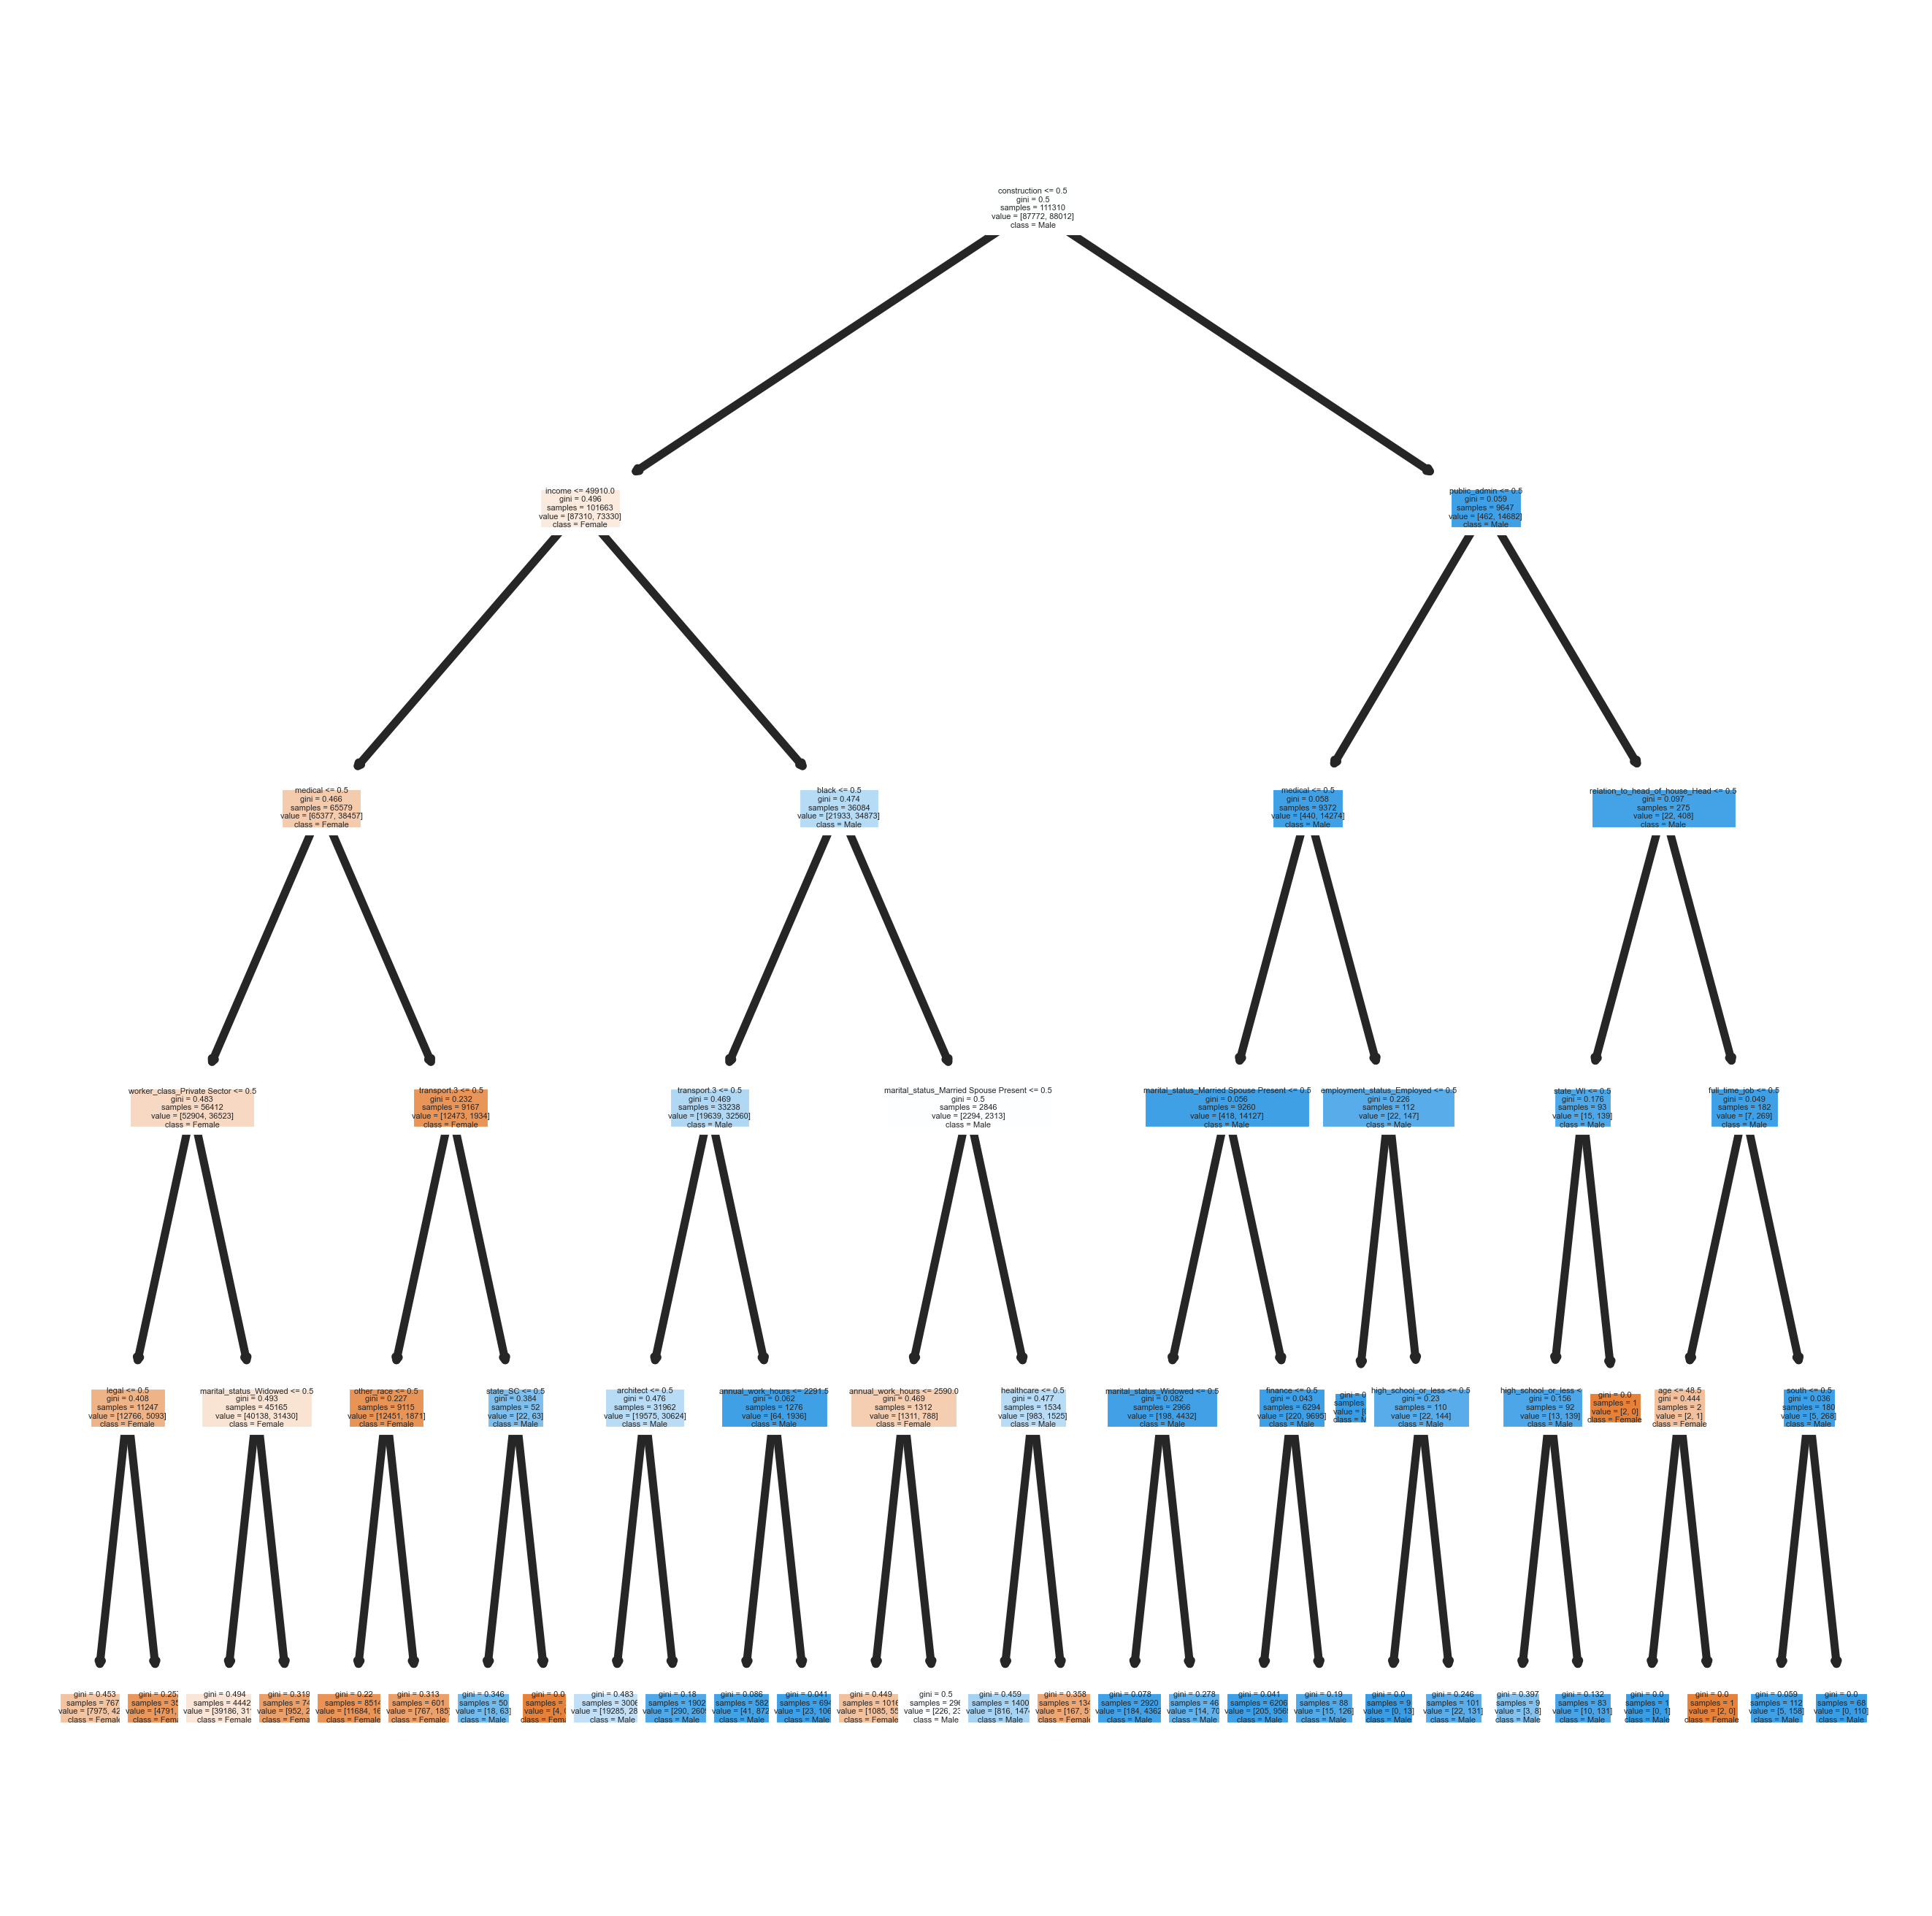

In [101]:
# visualize a single decision tree
rf.estimator_
fn=x_test_transformed.columns.to_list()
cn=list(rf.classes_)
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rf.estimators_[0],
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig('tree.png')

### Confusion Matrix

In [102]:
confusion_matrix(Y_test, rf_ypred_test)

array([[16079,  5811],
       [ 5229, 16828]], dtype=int64)

In [103]:
xxx = x_train_transformed.columns.to_list()

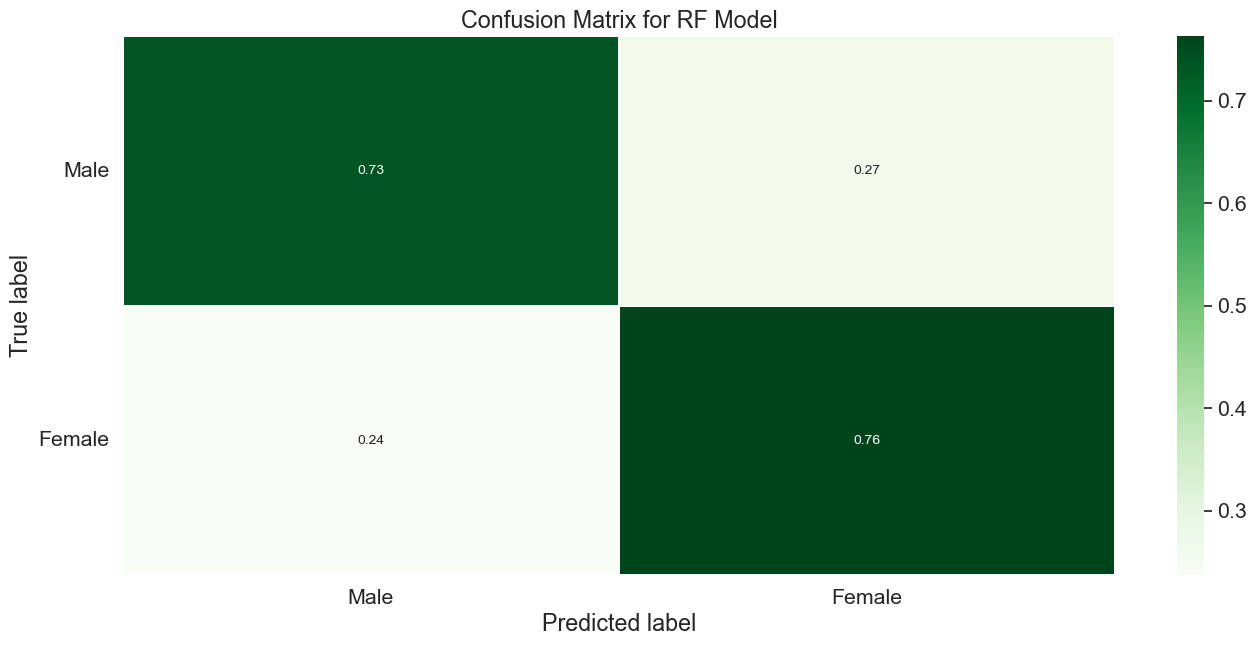

In [104]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(Y_test, rf_ypred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Male','Female']
tick_marks = np.arange(len(class_names))+0.5
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for RF Model')
plt.show()

### Classification Report

In [105]:
print(classification_report(Y_test, rf_ypred_test))

              precision    recall  f1-score   support

      Female       0.75      0.73      0.74     21890
        Male       0.74      0.76      0.75     22057

    accuracy                           0.75     43947
   macro avg       0.75      0.75      0.75     43947
weighted avg       0.75      0.75      0.75     43947



## Conclusion

Overall, predicting income is quite difficult. The data doesn't seem to have a strong relationship to income either due to the wide reaching nature of the survey or the actual lack of a relationship between the survey questions and income.

Using a plain logistic regression we achieved coin flip levels of accuracy.

Using a plain random forest, we achieved similar accuracy but significantly worse precision/recall/F1.


I think narrowing down the industry would greatly boost our ability to predict income and determine if gender is a significant predictor. Right now there are too many interactions and odd distributions to predict widely, across industries what someone's income will be. We even made income a categorical variable to help the accuracy along since trying to predict it as a numerical target resulted in RMSE's of around $50k which is huge and not very useful. 